In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras import layers, losses
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz as gp
import seaborn as sns
import keras_tuner as kt

In [ ]:
# pip install keras_tuner

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("Insurance_claims.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11530 entries, 0 to 11529
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ReferenceId                      11530 non-null  int64  
 1   PolicyholderNumber               11530 non-null  int64  
 2   FirstPartyVehicleNumber          11035 non-null  float64
 3   ThirdPartyVehicleNumber          379 non-null    float64
 4   InsurerNotes                     9173 non-null   object 
 5   PolicyholderOccupation           11187 non-null  object 
 6   LossDate                         11530 non-null  object 
 7   FirstPolicySubscriptionDate      11530 non-null  object 
 8   ClaimCause                       11333 non-null  object 
 9   ClaimInvolvedCovers              11335 non-null  object 
 10  DamageImportance                 738 non-null    object 
 11  FirstPartyVehicleType            11518 non-null  object 
 12  ConnectionBetweenP

# **1. Data Cleaning**

## Pre processing

In [6]:
# fill in missing values with NA
df["FirstPartyVehicleNumber"] = df["FirstPartyVehicleNumber"].fillna("NA")
df["ThirdPartyVehicleNumber"] = df["ThirdPartyVehicleNumber"].fillna("NA")
df["InsurerNotes"] = df["InsurerNotes"].fillna("NA")

# change the datatype to datetime
df['LossDate'] = pd.to_datetime(df['LossDate'])
df['FirstPolicySubscriptionDate'] = pd.to_datetime(df['FirstPolicySubscriptionDate'])

# fill in missing values with NoConnection
df["ConnectionBetweenParties"] = df["ConnectionBetweenParties"].fillna("NoConnection")

# extract the symbols and fill in missing values with NA
df["LossPostCode"] = df['LossPostCode'].str.extract(pat='(\d+)', expand=False)
df["LossPostCode"] = df['LossPostCode'].fillna("NA")

# missing values with NA
df["PolicyHolderPostCode"] = df["PolicyHolderPostCode"].fillna("NA")

# missing values with mean
df['FpVehicleAgeMonths'].fillna(df['FpVehicleAgeMonths'].mean(), inplace=True)
df['PolicyHolderAge'].fillna(df['PolicyHolderAge'].mean(), inplace=True)

# group data
for index, row in df.iterrows():
    if row['LossHour'] >= 0 and row['LossHour'] < 4:
        df.loc[index,"LossHour"] = '0-3'
    if row['LossHour'] >= 4 and row['LossHour'] < 8:
        df.loc[index,"LossHour"] = '4-7'
    if row['LossHour'] >= 8 and row['LossHour'] < 12:
        df.loc[index,"LossHour"] = '8-11'
    if row['LossHour'] >= 12 and row['LossHour'] < 16:
        df.loc[index,"LossHour"] = '12-15'
    if row['LossHour'] >= 16 and row['LossHour'] < 20:
        df.loc[index,"LossHour"] = '16-19'
    if row['LossHour'] >= 20 and row['LossHour'] <= 23:
        df.loc[index,"LossHour"] = '20-23'
# fill in data with mode
df['LossHour'].fillna(df['LossHour'].mode()[0], inplace=True)

In [7]:
# Colume ClaimInvolvedCovers
x = pd.DataFrame(df['ClaimInvolvedCovers'].str.split(' ',expand=True))
unique = pd.DataFrame(pd.concat([x[0],x[1],x[2],x[3],x[4]]).unique(), columns=['types'])
unique = unique.dropna().reset_index(drop=True)
uniqueL = unique['types'].tolist()
for j in np.arange(0,len(uniqueL)):
    cat = uniqueL[j]
    aa = [0]*11530
    for i in [0,1,2,3,4]:
        aa = aa + np.array((x[i] == cat)*1)
    #aa
    df['ClaimInvolvedCovers_'+uniqueL[j]] = aa
df = df.drop(columns=["ClaimInvolvedCovers"])

# Colume DamageImportance
df['DamageImportance'] = df['DamageImportance'].fillna("Negligible")


In [8]:
# create new column
df['Date_diff'] = (df['LossDate'] - df['FirstPolicySubscriptionDate']).dt.days

In [9]:
df_clean = df.copy()

In [10]:
# get dummy
df_clean=df_clean.merge(pd.get_dummies(df_clean.LossHour,prefix="LH",
                                       prefix_sep="_"),left_index=True, right_index=True)
df_clean=df_clean.merge(pd.get_dummies(df_clean.ConnectionBetweenParties,prefix="CBP",
                                       prefix_sep="_"),left_index=True, right_index=True)
df_clean=df_clean.merge(pd.get_dummies(df_clean.PolicyholderOccupation,prefix="PO",
                                       prefix_sep="_"),left_index=True, right_index=True)
df_clean=df_clean.merge(pd.get_dummies(df_clean.ClaimCause,prefix="CC",
                                       prefix_sep="_"),left_index=True, right_index=True)
df_clean=df_clean.merge(pd.get_dummies(df_clean.DamageImportance,prefix="DI",
                                       prefix_sep="_"),left_index=True, right_index=True)
df_clean=df_clean.merge(pd.get_dummies(df_clean.FirstPartyVehicleType,prefix="FPVT",
                                       prefix_sep="_"),left_index=True, right_index=True)

df_clean = df_clean.drop(['ConnectionBetweenParties', 'PolicyholderOccupation',"ClaimCause",
               "DamageImportance","FirstPartyVehicleType",
               "LossHour"], axis=1)

In [11]:
df_clean1 = df_clean.copy()

In [12]:
# drop columns we don't need
df_clean1 = df_clean1.drop(['ReferenceId', 'PolicyholderNumber',"FirstPartyVehicleNumber",
               "ThirdPartyVehicleNumber","InsurerNotes",
               "LossPostCode","PolicyHolderPostCode","LossDate","FirstPolicySubscriptionDate"], axis=1)

In [13]:
df_clean1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11530 entries, 0 to 11529
Data columns (total 72 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   PolicyWasSubscribedOnInternet                  11530 non-null  int64  
 1   NumberOfPoliciesOfPolicyholder                 11530 non-null  int64  
 2   FpVehicleAgeMonths                             11530 non-null  float64
 3   EasinessToStage                                11530 non-null  float64
 4   ClaimWihoutIdentifiedThirdParty                11530 non-null  int64  
 5   ClaimAmount                                    11530 non-null  float64
 6   PolicyHolderAge                                11530 non-null  float64
 7   NumberOfBodilyInjuries                         11530 non-null  int64  
 8   FirstPartyLiability                            11530 non-null  float64
 9   Fraud                                          115

In [14]:
df_clean1.to_csv("Insurance_claims_clean.csv")

# **4. Neural Network**

## 4.1 Split data

In [42]:
df = pd.read_csv("Insurance_claims_clean.csv")

In [43]:
df = df.drop(columns=['Unnamed: 0'])

In [44]:
dfC = df.copy()
dfC1 = dfC[dfC.Fraud==1]
dfC0 = dfC[dfC.Fraud==0]

In [45]:
dfX1 = dfC1.drop(columns=["Fraud"])
dfY1 = dfC1[["Fraud"]]

dfX0 = dfC0.drop(columns=["Fraud"])
dfY0 = dfC0[["Fraud"]]

In [46]:
X1_train, X1_test, y1_train, y1_test = train_test_split(dfX1, dfY1, test_size=0.4, random_state=172)
X1_test, X1_val, y1_test, y1_val = train_test_split(X1_test, y1_test, test_size=0.5, random_state=172)

X0_train, X0_test, y0_train, y0_test = train_test_split(dfX0, dfY0, test_size=0.4, random_state=172)
X0_test, X0_val, y0_test, y0_val = train_test_split(X0_test, y0_test, test_size=0.5, random_state=172)

In [47]:
X_train = X1_train.append(X0_train)
X_val = X1_val.append(X0_val)
X_test = X1_test.append(X0_test)

y_train = y1_train.append(y0_train)
y_val = y1_val.append(y0_val)
y_test = y1_test.append(y0_test)

In [48]:
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((6918, 71), (2306, 71), (2306, 71), (6918, 1), (2306, 1), (2306, 1))

## 4.2 Build neural network

### 4.2.1 SGD

I started from a 2-hidden-layers SGD neural network, 10 units each, with 0.01 learning rate and 0.9 momentum. The accuracy does not improve after reaching 99.00%.

I then tried with a lower learning rate (0.001), a smaller batch size (16), adding L2 regularisation (0.9), adding dropout regularisation (0.2), having more units per hidden layer (20), having additional hidden layer. Even though some of the tested models have very big initial loss, all of them coverge to a small loss at the end.

However, none of them can improve the training and validation accuracy beyond 99.00%.

### 4.2.2 RMSprop

I tried with a RMSprop neural network, with 2 size-20 hidden layers, 0.2 dropout rate, 0.01 L2 regularisation parameter, batch size of 16. The result is still the same, having 99.00% training and validation accuracy, and the loss converging to a very small value.

### 4.2.3 Adam

I tried with an Adam neural network, with a same setting as the RMSprop one, having a 0.9 beta 1, 0.999 beta 2, and 1e-07 epsilon. The result is not the same, but very similar, having 98.99% training accuracy, 99.00% validation accuracy.

In [49]:
num_units = 20

reg_param = 0.01
regularizer = tf.keras.regularizers.l2(reg_param)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(num_units, activation="relu", kernel_regularizer=regularizer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(num_units, activation="relu", kernel_regularizer=regularizer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=regularizer)
])

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics=["accuracy"])

log1Adam = model.fit(X_train, y_train, epochs=10, batch_size=16,
                    validation_data=(X_val, y_val))

Epoch 1/10
433/433 [==============================] - 2s 3ms/step - loss: 13.8192 - accuracy: 0.9295 - val_loss: 7.3495 - val_accuracy: 0.9900
Epoch 2/10
433/433 [==============================] - 1s 2ms/step - loss: 5.1478 - accuracy: 0.9733 - val_loss: 3.9275 - val_accuracy: 0.9900
Epoch 3/10
433/433 [==============================] - 1s 2ms/step - loss: 2.6844 - accuracy: 0.9750 - val_loss: 2.2672 - val_accuracy: 0.9900
Epoch 4/10
433/433 [==============================] - 1s 2ms/step - loss: 1.8396 - accuracy: 0.9780 - val_loss: 0.7432 - val_accuracy: 0.9900
Epoch 5/10
433/433 [==============================] - 1s 2ms/step - loss: 1.0467 - accuracy: 0.9789 - val_loss: 0.6304 - val_accuracy: 0.9900
Epoch 6/10
433/433 [==============================] - 1s 2ms/step - loss: 0.6199 - accuracy: 0.9809 - val_loss: 0.3853 - val_accuracy: 0.9900
Epoch 7/10
433/433 [==============================] - 1s 3ms/step - loss: 0.4838 - accuracy: 0.9855 - val_loss: 0.2388 - val_accuracy: 0.9900
Epoch

As all 3 models have the same result, I then use Adam for hyperparameter tuning.

In [50]:
rm -rf ./logs/kt_tutorial_2

In [51]:
def train_model(hp):    
    num_units = hp.Int('num_units', min_value = 8, max_value = 128) 
    dropout_rate = hp.Float('dropout_rate', min_value = 0.1, max_value = 0.3)
    learning_rate = hp.Float('learning_rate', min_value = 0.0001, max_value = 0.1, sampling='log')

    reg_param = hp.Choice("reg_param", [0.1, 0.01, 0.001, 0.0001])
    regularizer = tf.keras.regularizers.l2(reg_param)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_units, activation="relu", kernel_regularizer=regularizer),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_units, activation="relu", kernel_regularizer=regularizer),
        tf.keras.layers.Dense(1, activation="sigmoid")])
    
    model.compile(  optimizer=tf.keras.optimizers.experimental.Adam(learning_rate = learning_rate,
                                                                    beta_1 = 0.9, beta_2 = 0.999,
                                                                    epsilon = 1e-07),
                    loss='binary_crossentropy',
                    metrics = ["accuracy"])
    
    return model

In [52]:
tuner = kt.Hyperband(train_model,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=3,
                     directory='logs',
                     project_name='kt_tutorial_2')
tuner.search(X_train, y_train, validation_data=(X_val,y_val))

Trial 10 Complete [00h 00m 06s]
val_accuracy: 0.9900259971618652

Best val_accuracy So Far: 0.9900259971618652
Total elapsed time: 00h 00m 37s


In [53]:
best_hps = tuner.get_best_hyperparameters()[0]
print("Best number of hidden units:", best_hps['num_units'])
print("Best dropout rate:", best_hps['dropout_rate'])
print("Best learning rate:", best_hps['learning_rate'])
print("Best L2 reg parameter:", best_hps['reg_param'])


best_model = tuner.hypermodel.build(best_hps)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

log = best_model.fit(X_train, y_train,
               epochs=30,
               validation_data=(X_test,y_test),
               callbacks=[early_stopping_cb])

Best number of hidden units: 42
Best dropout rate: 0.1400688086537003
Best learning rate: 0.0004827637265189225
Best L2 reg parameter: 0.001
Epoch 1/30
217/217 [==============================] - 2s 4ms/step - loss: 2.4870 - accuracy: 0.9579 - val_loss: 0.5984 - val_accuracy: 0.9900
Epoch 2/30
217/217 [==============================] - 1s 3ms/step - loss: 0.8579 - accuracy: 0.9790 - val_loss: 7.5491 - val_accuracy: 0.7298
Epoch 3/30
217/217 [==============================] - 1s 3ms/step - loss: 0.8982 - accuracy: 0.9815 - val_loss: 0.4343 - val_accuracy: 0.9900
Epoch 4/30
217/217 [==============================] - 1s 3ms/step - loss: 0.8162 - accuracy: 0.9828 - val_loss: 0.2415 - val_accuracy: 0.9900
Epoch 5/30
217/217 [==============================] - 1s 3ms/step - loss: 0.5794 - accuracy: 0.9796 - val_loss: 0.3552 - val_accuracy: 0.9900
Epoch 6/30
217/217 [==============================] - 1s 2ms/step - loss: 0.6506 - accuracy: 0.9812 - val_loss: 0.2787 - val_accuracy: 0.9900
Epoch 7

## 2.3 Find optimal threshold for classification

In [55]:
load_model = tf.keras.models.load_model('Neural Network_final_model.h5')

log = load_model.fit(X_train, y_train,
               epochs=30,
               validation_data=(X_val,y_val),
               callbacks=[early_stopping_cb])

Epoch 1/30
217/217 [==============================] - 1s 3ms/step - loss: 1.0369 - accuracy: 0.9840 - val_loss: 1.0152 - val_accuracy: 0.9900
Epoch 2/30
217/217 [==============================] - 0s 2ms/step - loss: 0.9996 - accuracy: 0.9855 - val_loss: 0.8816 - val_accuracy: 0.9900
Epoch 3/30
217/217 [==============================] - 0s 2ms/step - loss: 1.0151 - accuracy: 0.9792 - val_loss: 0.9475 - val_accuracy: 0.9900
Epoch 4/30
217/217 [==============================] - 1s 3ms/step - loss: 0.9782 - accuracy: 0.9842 - val_loss: 0.7951 - val_accuracy: 0.9900
Epoch 5/30
217/217 [==============================] - 1s 2ms/step - loss: 0.9470 - accuracy: 0.9850 - val_loss: 1.1629 - val_accuracy: 0.9900
Epoch 6/30
217/217 [==============================] - 1s 2ms/step - loss: 0.9521 - accuracy: 0.9822 - val_loss: 0.8229 - val_accuracy: 0.9900
Epoch 7/30
217/217 [==============================] - 1s 2ms/step - loss: 0.8353 - accuracy: 0.9850 - val_loss: 0.8254 - val_accuracy: 0.9900
Epoch 

In [56]:
load_model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 71),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dropout_2_input'}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_2',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.1647608817858867,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_3',
    'trainable': True,
    'dtype': 'float32',
    'units': 28,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': {'class_name': 'L2',
     'config': {'l2': 0.10000000149011612}},
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_

In [57]:
threshold_list = np.arange(0, 0.4, 0.01)

y_probs = load_model(X_test).numpy() 
d = [-1]
h = [-1]

for threshold in threshold_list:

  y_preds = np.where(y_probs < threshold, 0, 1)
  tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_preds).ravel()

  detectionRate = (tp+fp)/len(X_test)
  hitRate = tp / (tp+fp)

  d.append(detectionRate)
  h.append(hitRate)

d = d[1:]
h = h[1:]

len(d), len(h)

<ipython-input-57-62e3c34e1566>:13: RuntimeWarning: invalid value encountered in long_scalars
  hitRate = tp / (tp+fp)
<ipython-input-57-62e3c34e1566>:13: RuntimeWarning: invalid value encountered in long_scalars
  hitRate = tp / (tp+fp)
<ipython-input-57-62e3c34e1566>:13: RuntimeWarning: invalid value encountered in long_scalars
  hitRate = tp / (tp+fp)
<ipython-input-57-62e3c34e1566>:13: RuntimeWarning: invalid value encountered in long_scalars
  hitRate = tp / (tp+fp)
<ipython-input-57-62e3c34e1566>:13: RuntimeWarning: invalid value encountered in long_scalars
  hitRate = tp / (tp+fp)
<ipython-input-57-62e3c34e1566>:13: RuntimeWarning: invalid value encountered in long_scalars
  hitRate = tp / (tp+fp)
<ipython-input-57-62e3c34e1566>:13: RuntimeWarning: invalid value encountered in long_scalars
  hitRate = tp / (tp+fp)
<ipython-input-57-62e3c34e1566>:13: RuntimeWarning: invalid value encountered in long_scalars
  hitRate = tp / (tp+fp)
<ipython-input-57-62e3c34e1566>:13: RuntimeWarni

(40, 40)

In [58]:
NNdh = pd.DataFrame(list(zip(threshold_list, d, h)), columns=['Threshold', 'Detection_rate', 'Hit_rate'])

In [59]:
NNdh.to_csv("NN_dh.csv")

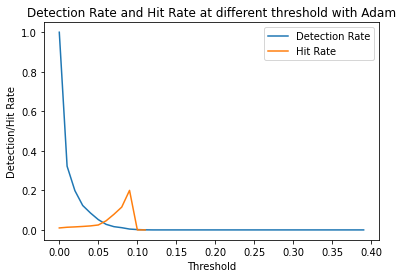

In [60]:
plt.plot(NNdh.Threshold, NNdh.Detection_rate, label='Detection Rate')
plt.plot(NNdh.Threshold, NNdh.Hit_rate, label='Hit Rate')
plt.title("Detection Rate and Hit Rate at different threshold with Adam")
plt.xlabel("Threshold")
plt.ylabel("Detection/Hit Rate")
plt.legend()

## 2.4 Loss part

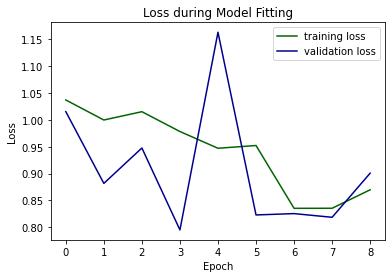

In [61]:
plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Model Fitting")
plt.legend()
plt.show()

# **6. Detection VS Hit Rate with Different Models**

In [88]:
# Decision Tree
DTdh = pd.read_csv("DecisionTree_dh.csv")
DTdh = DTdh.drop(columns=['Unnamed: 0']).sort_values("Threshold")

In [89]:
# Neural Network
NNdh = pd.read_csv("NN_dh.csv")
NNdh = NNdh.drop(columns=['Unnamed: 0']).sort_values("Threshold")

In [90]:
# Autoencoder
AEdh = pd.read_csv("Autoencoder_dh.csv")
AEdh = AEdh.drop(columns=['Unnamed: 0']).sort_values("Threshold")

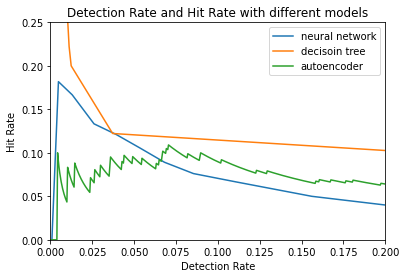

In [91]:
plt.plot(NNdh.Detection_rate, NNdh.Hit_rate, label="neural network")
plt.plot(DTdh.Detection_rate, DTdh.Hit_rate, label="decisoin tree")
plt.plot(AEdh.Detection_rate, AEdh.Hit_rate, label="autoencoder")
plt.title("Detection Rate and Hit Rate with different models")
plt.xlabel("Detection Rate")
plt.ylabel("Hit Rate")
plt.ylim(0,0.25)
plt.xlim(0,0.2)
plt.legend()
plt.show()